# 8. GRUによる多変量時系列予測

## 概要
- **内容:** 本Notebookは、PyTorchを用いてGRUモデルを構築し、太陽光発電量と電力需要量の時系列予測を行う。データ準備、モデル定義、初期予測、Optunaによるハイパーパラメータ最適化、そして最適化後の最終予測という流れで実験を進める。

### 8-1. 目的
本ノートブックの目的は、PyTorchを用いてGRU（Gated Recurrent Unit）モデルを構築し、これまでの分析で特定した外部特徴量を含む多変量時系列データから、ターゲットである太陽光発電量、電力需要量を予測することである。

ARIMAモデルやProphetモデルでは捉えきれなかった、複数の特徴量間の非線形な関係性を捉え、予測精度の向上を目指す。特に、イベントやプロモーションなどの外部特徴量が売上に与える影響をモデルに組み込むことで、より現実に即した予測を試みる。

### 8-2. データ準備

#### 8-2-1. ライブラリのインポートとデータ読み込み
予測モデルの構築に必要なライブラリをインポートし、前処理済みのデータを読み込む。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import List, Tuple, Callable, Dict, Optional, Any

import optuna

# 共通モジュールのインポート
from src.data_utils import load_timeseries_data
from src.evaluation_utils import evaluate_forecast
from src.plot_utils import plot_forecast_vs_actual

# スタイル設定
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['font.family'] = 'Meiryo'

# スタイルと警告の設定
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['font.family'] = 'Meiryo'
warnings.filterwarnings('ignore')

# デバイス設定 (GPUがあれば'cuda'、なければ'cpu')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# load data
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR.parent / "data"
target_file = DATA_DIR / "df_shifted.csv"

df = load_timeseries_data(target_file)

print("データ形状:", df.shape)
print("データ期間:", df.index.min(), "から", df.index.max())
df.head()

データ形状: (39360, 16)
データ期間: 2023-01-01 00:00:00 から 2025-03-30 23:30:00


,is_holiday,sin_hour,cos_hour,sin_weekday,cos_weekday,pressure_local,precipitation,temperature,dew_point,vapor_pressure,humidity,wind_speed,sunshine_duration,solar_radiation,solar_shifted,demand_shifted
datetime,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,1,0.000000,1.000000,-0.781831,0.62349,1018.20,0.0,3.80,-0.60,5.9,73.0,1.80,0.0,0.0,0.0,26500.0
2023-01-01 00:30:00,1,0.000000,1.000000,-0.781831,0.62349,1018.05,0.0,3.65,-0.55,5.9,74.0,1.40,0.0,0.0,0.0,25590.0
2023-01-01 01:00:00,1,0.258819,0.965926,-0.781831,0.62349,1017.90,0.0,3.50,-0.50,5.9,75.0,1.00,0.0,0.0,0.0,24850.0
2023-01-01 01:30:00,1,0.258819,0.965926,-0.781831,0.62349,1018.00,0.0,3.35,-0.75,5.8,74.5,1.15,0.0,0.0,0.0,24460.0
2023-01-01 02:00:00,1,0.500000,0.866025,-0.781831,0.62349,1018.10,0.0,3.20,-1.00,5.7,74.0,1.30,0.0,0.0,0.0,24430.0


#### 8-2-2. GRUモデルとデータセット関数の定義

In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_len, dropout_rate):
        super(GRUModel, self).__init__()
        self.output_len = output_len
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout_rate if num_layers > 1 else 0)
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_len)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        output, h_n = self.gru(x)
        # h_n shape: (num_layers, batch_size, hidden_size)
        final_hidden = h_n[-1]
        # final_hidden shape: (batch_size, hidden_size)
        pred = self.fc(final_hidden)
        # pred shape: (batch_size, output_len)
        return pred

def make_dataset(X, y, time_steps, y_length):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - y_length + 1):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps:i + time_steps + y_length])
    return np.array(Xs), np.array(ys)

#### 8-2-3. 共通パラメータと変数の定義

In [4]:
# スライディングウィンドウ設定
TRAIN_LENGTH = 2880  # 60 days
TEST_LENGTH = 48     # 1 day
SLIDE_COUNT = 30     # 30 days
STRIDE = 48          # 1 day

# GRUモデル・学習設定
SEQUENCE_LENGTH = 48  # 1日間分のデータを1シーケンスとする
N_EPOCHS = 15
OPTUNA_N_TRIALS = 20 # Optunaの試行回数

# 目的変数と説明変数の定義
TARGET_SOLAR = 'solar_shifted'
FEATURES_SOLAR = [
    'solar_radiation', 'cos_hour', 'sunshine_duration', 'temperature','sin_hour', 
    'pressure_local', 'precipitation', 'humidity', 'wind_speed', 'sin_weekday'
]

TARGET_DEMAND = 'demand_shifted'
FEATURES_DEMAND = [
    'vapor_pressure', 'temperature', 'humidity', 'sin_hour', 'cos_hour','solar_radiation', 
    'sin_weekday', 'cos_weekday', 'is_holiday', 'pressure_local', 'precipitation'
]

### 8-3. 予測実行プロセスの定義
- 本分析では、Sliding Window（スライディングウィンドウ）法を用いて時系列予測を行う。この手法では、学習と予測をウィンドウ単位で繰り返し実行する。

- この複雑なプロセスを管理するため、一連の処理（データ分割、スケーリング、シーケンス作成、モデル学習、予測、評価）をカプセル化した`run_prediction`関数を定義する。特に、各ウィンドウ内で学習データのみを用いてスケーリングを行うことで、テストデータからの情報リークを厳密に防止する設計とした。

In [5]:
def run_prediction(
    target_col,
    feature_cols,
    mase_period,
    model_params,
    run_title,
    y_shift = None  # y_shift を使用した場合もとに戻すため,　デフォルトは不使用
):
    """
    Run sliding-window forecasting using a GRU model (multi-step).
    Supports optional post-alignment by shifting prediction DataFrame.

    Parameters
    ----------
    target_col : str
        Column name of the target variable.
    feature_cols : list of str
        Names of explanatory feature columns.
    mase_period : int
        Seasonal period for MASE evaluation.
    model_params : dict
        GRU hyperparameters. Expected keys:
            ['hidden_size', 'num_layers', 'dropout_rate',
             'batch_size', 'lr'].
    run_title : str
        Title printed for logging and used in plots.
    y_shift : int or None, default None
        If provided, the concatenated result DataFrame is shifted by
        this amount (positive values shift forward). `dropna()` is
        applied afterward.

    Returns
    -------
    results_df : pd.DataFrame
        DataFrame containing the concatenated true and predicted values
        across all sliding windows. Index corresponds to original timestamps.
    metrics : dict
        Evaluation metrics including MAE, RMSE, MASE, etc.

    Notes
    -----
    - Requires global variables: df, TRAIN_LENGTH, TEST_LENGTH,
      SLIDE_COUNT, STRIDE, SEQUENCE_LENGTH, N_EPOCHS, DEVICE.
    - A fresh GRU model is trained for each sliding window.
    - Scaling uses training data only (MinMaxScaler).
    - Multi-step forecasting uses the last SEQUENCE_LENGTH samples.
    - If y_shift is provided, index alignment changes after shift/dropna.
    """
    print(f"--- {run_title} ---")
    
    all_preds = []
    y_train_for_mase = df[target_col].iloc[:TRAIN_LENGTH].values
    
    # 特徴量に目的変数自身も加える
    all_feature_cols = feature_cols + [target_col]

    for i in tqdm(range(SLIDE_COUNT), desc=f"Sliding Window for {target_col}"):
        # 1. データウィンドウの分割
        train_start = i * STRIDE
        train_end = train_start + TRAIN_LENGTH
        test_end = train_end + TEST_LENGTH
        if test_end > len(df):
            break

        train_df = df.iloc[train_start:train_end]
        test_df = df.iloc[train_end:test_end]

        # 2. スケーリング
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()

        X_train_scaled = X_scaler.fit_transform(train_df[all_feature_cols])
        y_train_scaled = y_scaler.fit_transform(train_df[[target_col]]).flatten()
        
        # 3. シーケンスデータ作成
        X_train_seq, y_train_seq = make_dataset(
            X_train_scaled, y_train_scaled, SEQUENCE_LENGTH, TEST_LENGTH
        )
        
        if X_train_seq.shape[0] == 0:
            print(f"Window {i+1}: Not enough data to create sequences. Skipping.")
            continue

        X_train_tensor = torch.FloatTensor(X_train_seq).to(DEVICE)
        y_train_tensor = torch.FloatTensor(y_train_seq).to(DEVICE)
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=model_params['batch_size'], shuffle=True)

        # 4. モデル学習
        model = GRUModel(
            input_size=len(all_feature_cols),
            hidden_size=model_params['hidden_size'],
            num_layers=model_params['num_layers'],
            output_len=TEST_LENGTH,
            dropout_rate=model_params['dropout_rate']
        ).to(DEVICE)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=model_params['lr'])
        criterion = nn.MSELoss()

        model.train()
        for epoch in range(N_EPOCHS):
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()

        # 5. 予測
        model.eval()
        with torch.no_grad():
            # 予測用の入力シーケンスを作成 (学習データの最後のSEQUENCE_LENGTH分)
            input_sequence_scaled = X_train_scaled[-SEQUENCE_LENGTH:]
            input_tensor = torch.FloatTensor(input_sequence_scaled).unsqueeze(0).to(DEVICE)
            
            preds_scaled = model(input_tensor).cpu().numpy().flatten()

        # 6. スケールを元に戻す
        preds = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        
        df_i = pd.DataFrame({"true": test_df[target_col].values, "pred": preds}, index=test_df.index)
        all_preds.append(df_i)

    # 結果の集計と評価
    if not all_preds:
        print("予測結果がありません。")
        return

    results_df = pd.concat(all_preds)
    if y_shift is not None:
        results_df = results_df.shift(y_shift).dropna()
    metrics = evaluate_forecast(results_df['true'], results_df['pred'], y_train_for_mase, m=mase_period)
    
    print(f"評価指標 ({target_col}):")
    print(pd.DataFrame([metrics]))
    
    plot_forecast_vs_actual(results_df, f'{run_title}: {target_col}', days_to_show=10)

    return results_df, metrics

### 8-4. 太陽光発電量の予測 (`solar_gen_mw`)
最初に、ターゲット変数`solar_gen_mw`（太陽光発電量）の予測モデルを構築する。

#### 8-4-1. 初期パラメータによる予測
まず、経験的に設定した初期ハイパーパラメータを用いてベースラインとなるモデルを学習し、その予測精度を評価する。

--- 初期予測 ---


Sliding Window for solar_shifted:   0%|          | 0/30 [00:00<?, ?it/s]

評価指標 (solar_shifted):
           MAE         RMSE      MASE
0  2122.341861  2752.941132  2.884533


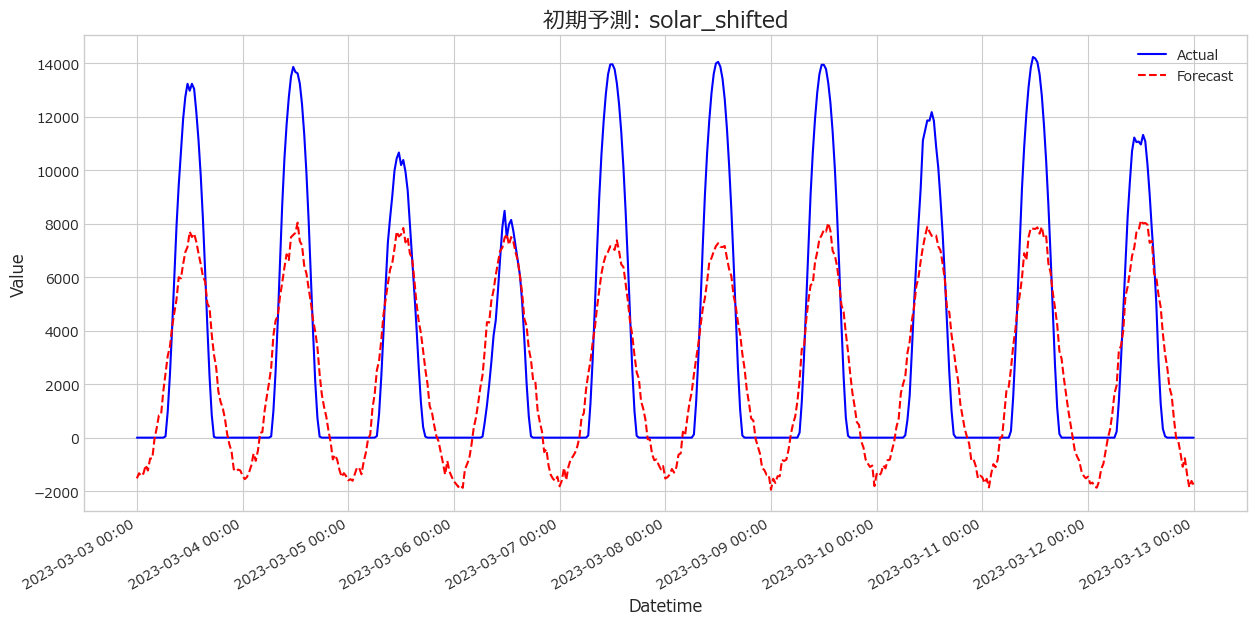

In [6]:
# 初期ハイパーパラメータ
initial_solar_params = {
    'hidden_size': 256,
    'num_layers': 2,
    'lr': 1e-4,
    'batch_size': 256,
    'dropout_rate': 0.3,
}

solar_initial_df, solar_initial_metrics = run_prediction(
    target_col=TARGET_SOLAR,
    feature_cols=FEATURES_SOLAR,
    mase_period=48,
    model_params=initial_solar_params,
    run_title="初期予測",
    y_shift=48
)

seqlen 48
```
評価指標 (solar_shifted):
          MAE         RMSE      MASE
0  2037.39874  2704.551639  2.769084
```

#### 8-4-2. Optunaによるハイパーパラメータ最適化
初期予測の精度を向上させるため、Optunaを用いてハイパーパラメータの最適化を行う。目的関数は検証データに対するRMSE（二乗平均平方根誤差）とし、この値を最小化するパラメータの組み合わせを探索する。

探索する主なハイパーパラメータは以下の通りである。
*   `hidden_size`: GRU層の隠れ状態の次元数
*   `num_layers`: GRU層の数
*   `lr`: 学習率
*   `batch_size`: バッチサイズ
*   `dropout_rate`: ドロップアウト率
*   `sequence_length`: シーケンス長

In [7]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def objective_solar(trial):
    set_seed(42)
    # チューニングは最初のTRAIN_LENGTH(60日間)のデータのみを使用
    tuning_df = df.iloc[:TRAIN_LENGTH].copy()
    
    # ハイパーパラメータの提案
    params = {
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 256]),
        'num_layers': trial.suggest_int('num_layers', 1, 3, 5),
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'sequence_length': trial.suggest_categorical('sequence_length', [48, 48*2, 48*7]),
    }
    
    all_feature_cols = FEATURES_SOLAR + [TARGET_SOLAR]
    
    # スライディングウィンドウの設定
    train_len = 48 * 48
    test_len = 48
    slide_count = 12
    stride = 48
    
    window_rmses = []

    for i in range(slide_count):
        train_start = i * stride
        train_end = train_start + train_len
        test_end = train_end + test_len
        
        train_window_df = tuning_df.iloc[train_start:train_end]
        test_window_df = tuning_df.iloc[train_end:test_end]

        # スケーリング
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
        X_train_scaled = X_scaler.fit_transform(train_window_df[all_feature_cols])
        y_train_scaled = y_scaler.fit_transform(train_window_df[[TARGET_SOLAR]]).flatten()
        
        # シーケンスデータ作成
        X_train_seq, y_train_seq = make_dataset(X_train_scaled, y_train_scaled, params['sequence_length'], test_len)
        if X_train_seq.shape[0] == 0: continue

        X_train_tensor = torch.FloatTensor(X_train_seq).to(DEVICE)
        y_train_tensor = torch.FloatTensor(y_train_seq).to(DEVICE)
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=params['batch_size'], shuffle=True)

        # モデル学習
        model = GRUModel(
            input_size=len(all_feature_cols), hidden_size=params['hidden_size'],
            num_layers=params['num_layers'], output_len=test_len,
            dropout_rate=params['dropout_rate']
        ).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
        criterion = nn.MSELoss()

        model.train()
        for epoch in range(N_EPOCHS):
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()

        # 評価
        model.eval()
        with torch.no_grad():
            input_sequence_scaled = X_train_scaled[-params['sequence_length']:]
            input_tensor = torch.FloatTensor(input_sequence_scaled).unsqueeze(0).to(DEVICE)
            preds_scaled = model(input_tensor).cpu().numpy().flatten()

        preds = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        rmse = np.sqrt(mean_squared_error(test_window_df[TARGET_SOLAR].values, preds))
        window_rmses.append(rmse)

    if not window_rmses:
        return float('inf') # or optuna.exceptions.TrialPruned()
        
    return np.mean(window_rmses)

# Optunaの実行
set_seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_solar = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_solar.optimize(objective_solar, n_trials=OPTUNA_N_TRIALS, show_progress_bar=True)

print("Best trial for Solar:")
best_params_solar = study_solar.best_params
print(f"  Value: {study_solar.best_value}")
print(f"  Params: {best_params_solar}")

  0%|          | 0/20 [00:00<?, ?it/s]

Best trial for Solar:
  Value: 1630.5934575834146
  Params: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.000189370370161544, 'batch_size': 64, 'dropout_rate': 0.1488007070906256, 'sequence_length': 96}


#### 8-4-3. 最適化パラメータによる最終予測
Optunaによって得られた最適なハイパーパラメータを用いて、再度モデルの学習と予測を実行し、ベースラインモデルからの性能向上を確認する。

--- 最適化後予測 ---


Sliding Window for solar_shifted:   0%|          | 0/30 [00:00<?, ?it/s]

評価指標 (solar_shifted):
           MAE         RMSE    MASE
0  1340.272051  2316.524625  1.8216


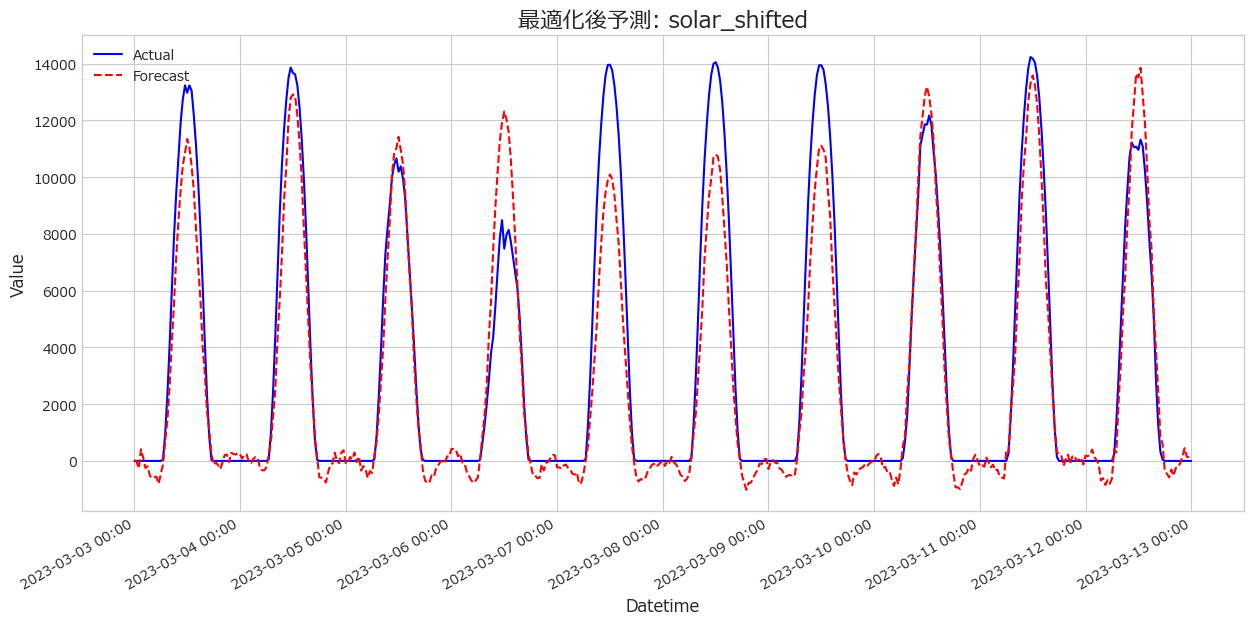

In [8]:
SEQUENCE_LENGTH = best_params_solar['sequence_length']
solar_tuned_df, solar_tuned_metrics = run_prediction(
    target_col=TARGET_SOLAR,
    feature_cols=FEATURES_SOLAR,
    mase_period=48,
    model_params=best_params_solar,
    run_title="最適化後予測",
    y_shift=48
)

### 8-5. 電力需要量の予測 (`e_demand_mw`)
次に、ターゲット変数`e_demand_mw`（電力需要量）の予測モデルを構築する。太陽光発電量と同様のプロセスで分析を進める。

#### 8-5-1. 初期パラメータによる予測
電力需要量予測においても、まず初期ハイパーパラメータによるベースラインモデルを構築し、評価を行う。

--- 初期予測 ---


Sliding Window for demand_shifted:   0%|          | 0/30 [00:00<?, ?it/s]

評価指標 (demand_shifted):
           MAE         RMSE     MASE
0  2905.577226  3521.859078  0.92009


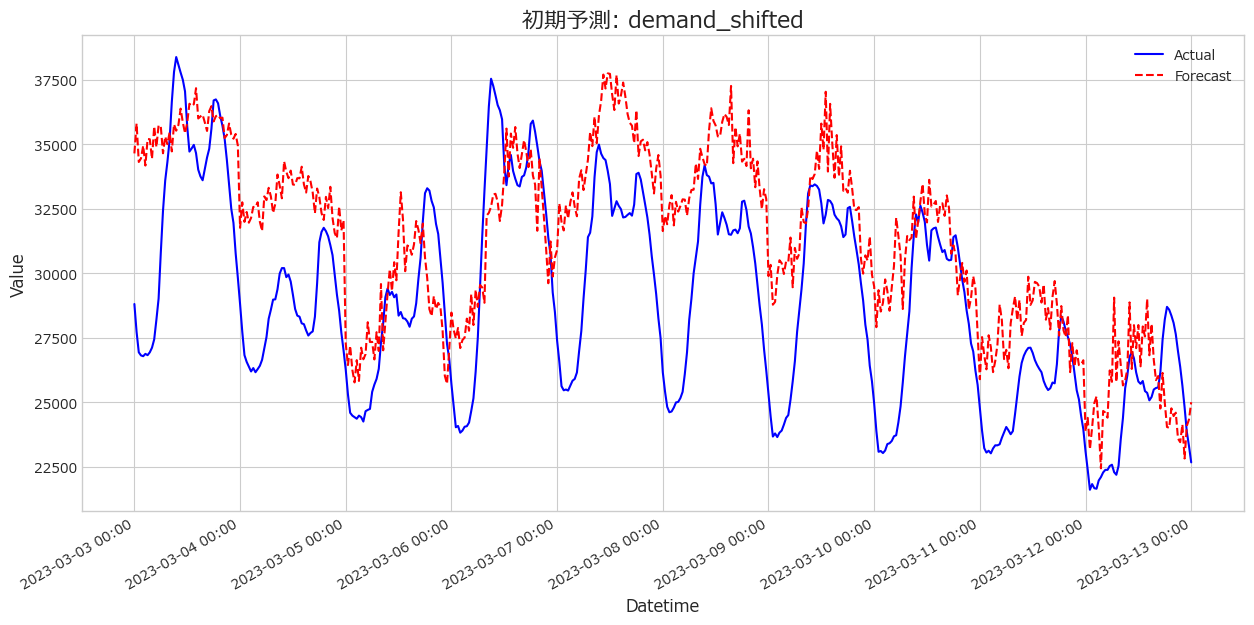

In [9]:
SEQUENCE_LENGTH = 336
# 初期ハイパーパラメータ
initial_demand_params = {
    'hidden_size': 256,
    'num_layers': 3,
    'lr': 1e-4,
    'batch_size': 256,
    'dropout_rate': 0.3,
}

demand_initial_df, demand_initial_metrics = run_prediction(
    target_col=TARGET_DEMAND,
    feature_cols=FEATURES_DEMAND,
    mase_period=336,
    model_params=initial_demand_params,
    run_title="初期予測",
    y_shift=48
)

#### 8-5-2. Optunaによるハイパーパラメータ最適化
太陽光発電量と同様に、Optunaを用いて電力需要量予測モデルのハイパーパラメータ最適化を実施する。

In [10]:
def objective_demand(trial):
    set_seed(42)
    tuning_df = df.iloc[:TRAIN_LENGTH].copy()
    
    params = {
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 256]),
        'num_layers': trial.suggest_int('num_layers', 1, 3, 5),
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'sequence_length': trial.suggest_categorical('sequence_length', [48, 48*2, 48*7]),
    }
    
    all_feature_cols = FEATURES_DEMAND + [TARGET_DEMAND]
    
    train_len, test_len, slide_count, stride = 48 * 48, 48, 12, 48
    window_rmses = []

    for i in range(slide_count):
        train_start, train_end, test_end = i * stride, i * stride + train_len, i * stride + train_len + test_len
        train_window_df, test_window_df = tuning_df.iloc[train_start:train_end], tuning_df.iloc[train_end:test_end]

        X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
        X_train_scaled = X_scaler.fit_transform(train_window_df[all_feature_cols])
        y_train_scaled = y_scaler.fit_transform(train_window_df[[TARGET_DEMAND]]).flatten()
        
        X_train_seq, y_train_seq = make_dataset(X_train_scaled, y_train_scaled, params['sequence_length'], test_len)
        if X_train_seq.shape[0] == 0: continue

        train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_seq).to(DEVICE), torch.FloatTensor(y_train_seq).to(DEVICE)), batch_size=params['batch_size'], shuffle=True)

        model = GRUModel(len(all_feature_cols), params['hidden_size'], params['num_layers'], test_len, params['dropout_rate']).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
        criterion = nn.MSELoss()

        model.train()
        for epoch in range(N_EPOCHS):
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                loss = criterion(model(X_batch), y_batch)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            input_sequence_scaled = X_train_scaled[-params['sequence_length']:]
            preds_scaled = model(torch.FloatTensor(input_sequence_scaled).unsqueeze(0).to(DEVICE)).cpu().numpy().flatten()

        preds = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        rmse = np.sqrt(mean_squared_error(test_window_df[TARGET_DEMAND].values, preds))
        window_rmses.append(rmse)

    if not window_rmses: return float('inf')
    return np.mean(window_rmses)

optuna.logging.set_verbosity(optuna.logging.WARNING)
set_seed(42)
study_demand = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_demand.optimize(objective_demand, n_trials=OPTUNA_N_TRIALS, show_progress_bar=True)

print("Best trial for Demand:")
best_params_demand = study_demand.best_params
print(f"  Value: {study_demand.best_value}")
print(f"  Params: {best_params_demand}")

  0%|          | 0/20 [00:00<?, ?it/s]

Best trial for Demand:
  Value: 2655.576569093536
  Params: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0005816123061832371, 'batch_size': 64, 'dropout_rate': 0.23560565778823855, 'sequence_length': 96}


#### 8-5-3. 最適化パラメータによる最終予測
最適化されたハイパーパラメータセットを用いて最終的なモデルを学習させ、その予測精度を評価する。

--- 最適化後予測 ---


Sliding Window for demand_shifted:   0%|          | 0/30 [00:00<?, ?it/s]

評価指標 (demand_shifted):
          MAE         RMSE      MASE
0  2119.56211  2908.045839  0.671188


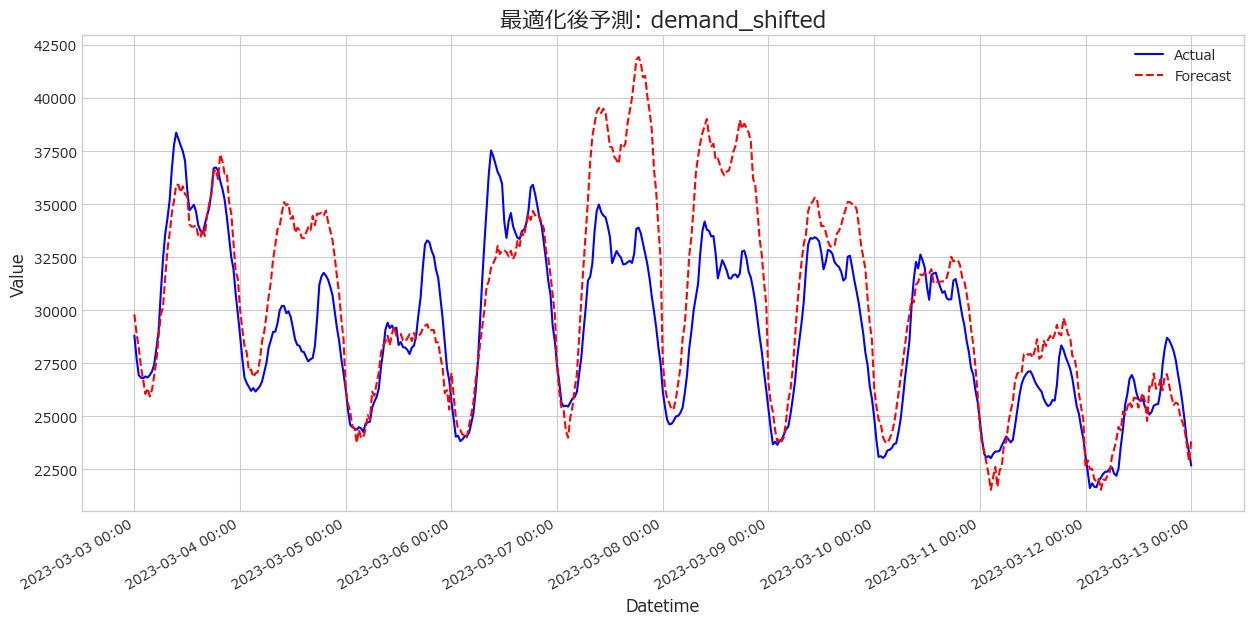

In [11]:
SEQUENCE_LENGTH = best_params_demand['sequence_length']
demand_tuned_df, demand_tuned_metrics = run_prediction(
    target_col=TARGET_DEMAND,
    feature_cols=FEATURES_DEMAND,
    mase_period=336,
    model_params=best_params_demand,
    run_title="最適化後予測",
    y_shift=48
)

In [12]:
# 評価結果表を結合
comparison_df = pd.DataFrame({
    'Solar_Initial': solar_initial_metrics,
    'Solar_Tuned': solar_tuned_metrics,
    'Demand_Initial': demand_initial_metrics,
    'Demand_Tuned': demand_tuned_metrics
})
print(comparison_df)

      Solar_Initial  Solar_Tuned  Demand_Initial  Demand_Tuned
MAE     2122.341861  1340.272051     2905.577226   2119.562110
RMSE    2752.941132  2316.524625     3521.859078   2908.045839
MASE       2.884533     1.821600        0.920090      0.671188


In [13]:
# 結果の保存
# pred_df には 'true', 'pred' カラムと datetime index がある前提

# solar_gen_mw
solar_tuned_df.to_pickle('../results/preds/solar_GRU.pkl')
print("Saved: ")

# e_demand_mw
demand_tuned_df.to_pickle('../results/preds/demand_GRU.pkl')
print("Saved: ")

Saved: 
Saved: 


### 8-6. 結論と考察
本分析では、PyTorchを用いてGRUモデルを構築し、太陽光発電量と電力需要量の多変量時系列予測を試みた。Optunaによるハイパーパラメータ最適化を通じて、初期モデルからの一定の精度向上（太陽光発電量予測のMASE: `2.90` → `1.83`）が確認された。

しかし、計算負荷に対し、特に消費ではGRUモデルの予測精度は不十分な結果となった。考察される要因は以下の通りである。
*   **物理的制約の表現**: 太陽光発電量は夜間にゼロになるという物理的制約を持つが、GRUモデルの予測値は夜間帯で振動し、負の値を取るなど不安定な挙動を示した。これは、モデルがデータの物理的背景を捉えきれていないことを示唆する。
*   **スパイク的な変動への追従性**: 電力需要量の予測では、全体的な傾向は捉えられているものの、特定日における急激な需要の増加（スパイク）を正確に予測できず、大きな誤差を生む一因となった。
*   **モデルの複雑性と効率**: GRUは時系列の依存関係を捉える強力なモデルであるが、今回のタスクにおいては、その複雑さが必ずしも高い予測精度に結びつかなかった。ハイパーパラメータの調整にも多くの試行を要した。しかしlightGBMと異なりチューニングで改善はしている。

一方で、本分析のプロセスには、結果の数値以上に重要な実践的知見が含まれている。特に、**Sliding Window法におけるデータリークの厳密な防止策**には注意を払った。各ウィンドウのループ内で学習データとテストデータを明確に分離し、スケーラーを学習データのみに適合させる処理を徹底した。これは、時系列モデルの汎化性能を公正に評価するための基本であり、分析者としての技術的信頼性を示す上で不可欠なプロセスである。

今回のGRUモデルの性能は期待に及ばなかったものの、この厳密なプロセス設計の経験と、深層学習モデルの特性（得意な点・不得意な点）に関する洞察は、今後のより高度な分析プロジェクトにおいて必ず活かされるものと考える。

**次工程への展開**
*   **モデルの制約条件の導入**: 太陽光発電量予測において、出力が非負になるような活性化関数（例: ReLU）を最終層に適用する、あるいは後処理で負の値をゼロにクリッピングするなどの改善を検討する。
*   **ハイブリッドモデルの検討**: ARIMAやProphetで捉えたトレンド・季節性成分と、GRUで捉えた残差（非線形成分）を組み合わせるハイブリッドモデルを構築する。
*   **Optunaの安定化**: 最適化結果のばらつきを抑えるため、`n_trials`を増やす、または`TPESampler`のシードを固定するなどの対策を検討する。